In [9]:
def get_relevant_activations(data, markup_for_tag):
    result = []
    for i, tag in enumerate(markup_for_tag):
        if tag != 0:
            result.append(data[i])
    return np.stack(result)


def get_matches(activations, markup):
    markup = np.array(markup)
    markup_devs = markup - np.mean(markup)
    activation_devs = activations - np.mean(activations, 0, keepdims=True)
    activation_stddevs = np.std(activations, 0, ddof=1, keepdims=True)
    markup_stddev = np.std(markup, ddof=1)
    activation_dev_fractions = activation_devs / (activation_stddevs + 1e-20)
    markup_dev_fractions = markup_devs / (markup_stddev + 1e-20)
    return activation_dev_fractions * np.reshape(markup_dev_fractions, [-1, 1])


def compute_stats(data, markup_for_tag):
    markup_for_tag = np.array(markup_for_tag)
    stats = {}
    stats['markup'] = markup_for_tag
    stats['relevant_markup'] = list(filter(lambda x: x != 0, markup_for_tag))
    stats['relevant_activations'] = get_relevant_activations(data, markup_for_tag)
    stats['matches'] = get_matches(stats['relevant_activations'], stats['relevant_markup'])
    stats['correlations'] = np.mean(stats['matches'], 0)
    assert stats['correlations'].ndim == 1
    stats['match_stddevs'] = np.std(stats['matches'], 0)
    stats['mean_square_correlation'] = np.sqrt(np.mean(stats['correlations']**2))
    stats['meta'] = {
        "positive": np.count_nonzero(markup_for_tag == 1),
        "negative": np.count_nonzero(markup_for_tag == -1),
        "total": len(stats['markup']),
    }
    return stats

In [11]:
import os
import pickle
import numpy as np

os.makedirs('test', exist_ok=True)

with open("test/test.pickle", 'wb') as f:
    pickle.dump(np.array([[4]*10]*50), f)

In [12]:
! ls -l test

итого 8
-rw-rw-r-- 1 anton anton 4160 июн  7 11:29 test.pickle


In [5]:
import tensorflow as tf

def get_axis_quarters(tensor):
    last_dim = tf.shape(tensor, out_type=tf.float32)[-1]
    exponents = tf.range(0., last_dim, 1., dtype=tf.float32)
    powers = tf.math.pow(2., exponents)
    binary_format = tf.cast(tensor > 0, tf.float32)
    linear_combination = powers * binary_format
    numbers = tf.reduce_sum(linear_combination, axis=-1)
    return tf.cast(numbers, tf.int32)

tensor = tf.constant(
    [[1, -1, 1],
     [-1, -1, -1]]
)

axis_quarters = get_axis_quarters(tensor)

with tf.Session() as sess:
    print(sess.run(axis_quarters))

[5 0]


In [17]:
import pickle
import numpy as np


tmpl = '/media/anton/DATA/results/h-elmo/expres/resrnn/poscorr/4/9/corr/level1_1/NNS/{}.pickle'
file_name = tmpl.format('correlations')
with open(file_name, 'rb') as f:
    corr = pickle.load(f)
    
print(max(corr))
print(np.argmax(corr))

0.579867856049573
62


In [1]:
from collections import Counter
import numpy as np

a = np.array([1, 2, 3])

c = Counter(a)
print(c)

Counter({1: 1, 2: 1, 3: 1})


In [3]:
matches = tmpl.format('matches')
with open(matches, 'rb') as f:
    m = pickle.load(f)

m62 = m[:, 62]
print(m62)
print(max(m62))
print(np.argmax(m62))
print(min(m62))
print(np.argmin(m62))

[ 0.08246549  0.02131961  0.08308583 ... -0.55830922  0.02906624
  0.02100856]
18.750923953380248
50567
-13.644160917601068
52351


In [4]:
print(np.std(m62))

2.387342495802599


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

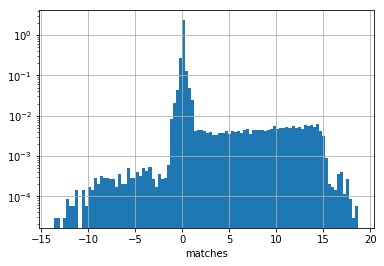

In [6]:
threshold = 0
f1 = m62[m62 > threshold]
f2 = m62[m62 <= -threshold]
filtered = np.concatenate([f1, f2])
plt.hist(filtered, bins=100, density=True)
plt.grid()
plt.yscale('log')
plt.xlabel('matches')

plt.show()

In [7]:
act = tmpl.format('relevant_activations')
with open(act, 'rb') as f:
    act = pickle.load(f)

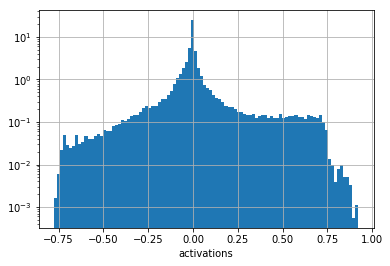

In [8]:
act62 = act[:, 62]
plt.hist(act62, bins=100, density=True)
plt.grid()
plt.yscale('log')
plt.xlabel('activations')

plt.show()

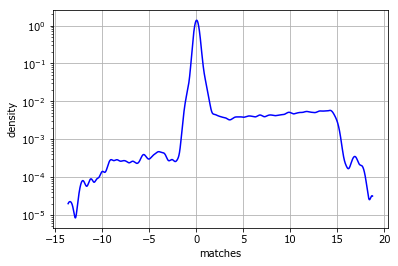

In [15]:
from helmo.util.plot.plot_helpers import density_plot

density_plot(m62, 0.001, None, 'blue')
plt.yscale('log')
plt.xlabel('matches')
plt.ylabel('density')
plt.grid()
plt.savefig(
    '/media/anton/DATA/results/h-elmo/expres/resrnn/poscorr/4/9/corr/level1_1/NNS/plots/matches.png',
    dpi=900
)
plt.show()

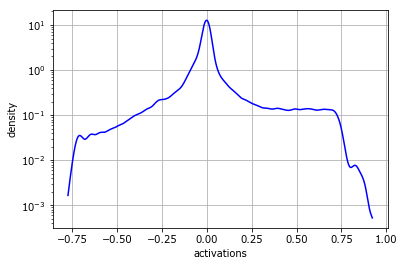

In [19]:
from helmo.util.plot.plot_helpers import density_plot

density_plot(act62, 0.0001, None, 'blue')
plt.yscale('log')
plt.xlabel('activations')
plt.ylabel('density')
plt.grid()
plt.savefig(
    '/media/anton/DATA/results/h-elmo/expres/resrnn/poscorr/4/9/corr/level1_1/NNS/plots/activations.png',
    dpi=900
)
plt.show()

In [171]:
! export PYTHONPATH="~/h-elmo:~/learning-to-learn"

In [173]:
! echo $PYTHONPATH

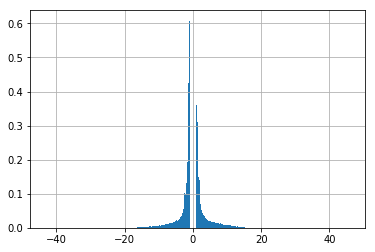

In [25]:
f1 = m[m > 1.]
f2 = m[m < -1.]
filtered = np.concatenate([f1, f2])
plt.hist(filtered, bins=1000, density=True)
plt.grid()
plt.show()

In [ ]:
tmpl = '/media/anton/DATA/results/h-elmo/expres/resrnn/poscorr/4/9/corr/level0_0/NNS/{}.pickle'
matches = tmpl.format('matches')
with open(matches, 'rb') as f:
    m = pickle.load(f)

In [ ]:
act = tmpl.format('activations')
with open(act, 'rb') as f:
    a = pickle.load(f)
    


In [ ]:
stddevs = tmpl.format('match_stddevs')
with open(stddevs, 'rb') as f:
    std = pickle.load(f)

print(std)
print(max(std))
print(np.argmax(std))

In [1]:
import tensorflow as tf


def get_all_values_except_specified(tensor, excluded):
    with tf.name_scope('get_all_values_except_specified'):
        tensor = tf.reshape(tensor, [-1])
        excluded = tf.reshape(excluded, [-1])
        excluded_shape = tf.shape(excluded)
        tensor_expanded = tf.reshape(tensor, [-1, 1])
        multiples = tf.concat([[1], excluded_shape], 0)
        tensor_expanded = tf.tile(tensor_expanded, multiples)
        masks = tf.cast(tf.equal(tf.cast(tensor_expanded, tf.int32), tf.cast(excluded, tf.int32)), tf.int32)
        mask = tf.reduce_sum(masks, [1])
        mask = tf.cast(tf.cast(mask, dtype=tf.bool), dtype=tf.int32) - 1
        return tf.boolean_mask(tensor, mask)
    

tensor, num_dims, axes, output = (
                    [[[1, 2], [3, 4]], [[5, 6], [7, 8]]],

                    5,

                    [0, 2, 4],

                    [[[[[1, 2]], [[3, 4]]], [[[5, 6]], [[7, 8]]]]],
                )

if not tf.contrib.framework.is_tensor(tensor):
    tensor = tf.constant(tensor)
if not tf.contrib.framework.is_tensor(axes):
    axes = tf.constant(axes, dtype=tf.int32)
sh = tf.shape(tensor, out_type=tf.int32)
nd = tf.shape(sh, out_type=tf.int32)[0]
assert_axes_smaller_than_num_dims = tf.assert_less(
    axes, num_dims, message='`axes` has to be less than `num_dims`')
check_num_dims = tf.assert_greater_equal(
    num_dims, nd,
    message='`num_dims` has to be greater or equal to number of dimensions in `tensor`'
)
ass_axes_bigger_or_equal_than_num_dims = tf.assert_greater_equal(axes, -num_dims)

negative_axes_mask = tf.cast(axes < 0, tf.int32)
axes += negative_axes_mask * num_dims

ones_for_expansion = tf.ones(tf.reshape(num_dims - nd, [1]), dtype=tf.int32)
shape_for_expansion = tf.concat([sh, ones_for_expansion], 0)

tensor = tf.reshape(tensor, shape_for_expansion)

# remained_axes = get_all_values_except_specified(tf.range(num_dims, dtype=tf.int32), axes)
# perm = tf.concat([axes, remained_axes], 0)
updates = tf.range(0, num_dims, 1, dtype=tf.int32)
remained_positions = get_all_values_except_specified(tf.range(num_dims, dtype=tf.int32), axes)
indices = tf.concat([axes, remained_positions], 0)
indices = tf.reshape(indices, [-1, 1])
perm_shape = tf.reshape(num_dims, [1])
perm = tf.scatter_nd(indices, updates, perm_shape)

with tf.control_dependencies([check_num_dims, assert_axes_smaller_than_num_dims, ass_axes_bigger_or_equal_than_num_dims]):
    tensor = tf.transpose(tensor, perm=perm)
    

with tf.Session() as sess:
    print(sess.run(tensor))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

[[[[[1 2]]

   [[3 4]]]]



 [[[[5 6]]

   [[7 8]]]]]


In [1]:
import numpy as np

from helmo.util.scripts.text_neuron_correlation import compute_stats

num_unrollings = 20
num_units = 4

# a = np.random.rand(num_units, num_unrollings)

m = np.random.choice([-1, 1, 0], num_unrollings)
a = np.stack([m]*num_units, 1)
print(a)

stats = compute_stats(a, m)
print(stats)

[[-1 -1 -1 -1]
 [ 1  1  1  1]
 [ 0  0  0  0]
 [-1 -1 -1 -1]
 [ 1  1  1  1]
 [-1 -1 -1 -1]
 [ 1  1  1  1]
 [-1 -1 -1 -1]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [ 0  0  0  0]
 [ 1  1  1  1]
 [ 0  0  0  0]
 [ 1  1  1  1]
 [ 0  0  0  0]
 [ 1  1  1  1]]
{'markup': array([-1,  1,  0, -1,  1, -1,  1, -1,  0,  0, -1, -1, -1, -1,  0,  1,  0,
        1,  0,  1]), 'relevant_markup': [-1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, 1], 'relevant_activations': array([[-1, -1, -1, -1],
       [ 1,  1,  1,  1],
       [-1, -1, -1, -1],
       [ 1,  1,  1,  1],
       [-1, -1, -1, -1],
       [ 1,  1,  1,  1],
       [-1, -1, -1, -1],
       [-1, -1, -1, -1],
       [-1, -1, -1, -1],
       [-1, -1, -1, -1],
       [-1, -1, -1, -1],
       [ 1,  1,  1,  1],
       [ 1,  1,  1,  1],
       [ 1,  1,  1,  1]]), 'matches': array([[0.75      , 0.75      , 0.75      , 0.75      ],
       [1.33333333, 1.33333333, 1.33333333, 1.33333333],
       [0.75      , 

In [161]:
import numpy as np


def get_int_part(n):
    return str(int(n // 1))


def get_frac_part(n):
    removed = int(get_int_part(n))
    frac_part = ''
    while n % 1:
        n *= 10
        removed *= 10
        frac_part += str(int(n // 1) - removed)
        removed = int(n // 1)
    return frac_part


def get_kth_digit(number, k, default='0'):
    """Returns k-th digit. For example, in number 123.45 1 
    is 2nd digit, 3 is zeroth and 5 is -2nd. 
    If the number does not have such a digit default is returned.
    Args:
        number: float or str convertable to float
        k: integer
    Returns:
        str"""
    if isinstance(number, str):
        number = float(number)
    int_part = get_int_part(number)
    frac_part = get_frac_part(number)
    number = int_part + frac_part
    k = len(int_part) - k - 1
    if 0 <= k < len(number):
        return number[k]
    else:
        return default
    
    
def get_first_nonzero_digit_pos(n):
    if n == 0:
        return None
    int_part = get_int_part(n)
    frac_part = get_frac_part(n)
    if int(int_part):
        return len(int_part) - 1
    i = 0
    while i < len(frac_part) and not int(frac_part[i]):
        i += 1
    assert frac_part[i] != '0'
    return -i - 1


def get_acc_num_digits(std, acc):
    if std == 0:
        return None
    
    std_err = std * acc
    
    nz_err = get_first_nonzero_digit_pos(std_err)
    
    digit_1_pos_higher = get_kth_digit(std, nz_err+1)
    
    higher_digit_change = get_kth_digit(std + std_err, nz_err+1) != digit_1_pos_higher or \
        get_kth_digit(std - std_err, nz_err+1) != digit_1_pos_higher

    if higher_digit_change:
        nz_err += 1
    return nz_err

for std in np.linspace(0, 1, 101):
    last_digit = get_acc_num_digits(std, 0.2)
    print(std, last_digit)

0.0 None
0.01 -2
0.02 -2
0.03 -2
0.04 -2
0.05 -2
0.06 -2
0.07 -2
0.08 -2
0.09 -1
0.1 -1
0.11 -1
0.12 -1
0.13 -2
0.14 -2
0.15 -2
0.16 -2
0.17 -1
0.18 -1
0.19 -1
0.2 -1
0.21 -1
0.22 -1
0.23 -1
0.24 -1
0.25 -1
0.26 -1
0.27 -1
0.28 -1
0.29 -1
0.3 -1
0.31 -1
0.32 -1
0.33 -1
0.34 -1
0.35000000000000003 -1
0.36 -1
0.37 -1
0.38 -1
0.39 -1
0.4 -1
0.41000000000000003 -1
0.42 -1
0.43 -1
0.44 -1
0.45 -1
0.46 -1
0.47000000000000003 -1
0.48 -1
0.49 -1
0.5 -1
0.51 -1
0.52 -1
0.53 -1
0.54 -1
0.55 -1
0.56 -1
0.5700000000000001 -1
0.58 -1
0.59 -1
0.6 -1
0.61 -1
0.62 -1
0.63 -1
0.64 -1
0.65 -1
0.66 -1
0.67 -1
0.68 -1
0.6900000000000001 -1
0.7000000000000001 -1
0.71 -1
0.72 -1
0.73 -1
0.74 -1
0.75 -1
0.76 -1
0.77 -1
0.78 -1
0.79 -1
0.8 -1
0.81 -1
0.8200000000000001 -1
0.8300000000000001 -1
0.84 0
0.85 0
0.86 0
0.87 0
0.88 0
0.89 0
0.9 0
0.91 0
0.92 0
0.93 0
0.9400000000000001 0
0.9500000000000001 0
0.96 0
0.97 0
0.98 0
0.99 0
1.0 0


In [138]:
get_kth_digit(123.45678, -4)

'7'

In [132]:
def get_first_nonzero_digit_pos_for_std(std, acc):
    if std == 0:
        return None
    std_fraction = std * acc
    int_part = get_int_part(std_fraction)
    frac_part = get_frac_part(std_fraction)
    if int(int_part):
        return len(int_part) - 1
    i = 0
    while i < len(frac_part) and not int(frac_part[i]):
        i += 1
    assert frac_part[i] != '0'
    return -i - 1


get_first_nonzero_digit_pos_for_std(0.0123456, 1000)

1

In [116]:
def get_int_part(n):
    return str(int(n // 1))


def get_frac_part(n):
    removed = int(get_int_part(n))
    frac_part = ''
    while n % 1:
        n *= 10
        removed *= 10
        frac_part += str(int(n // 1) - removed)
        removed = int(n // 1)
    return frac_part

len(get_frac_part(2.2250738585072014e-308))

324

In [1]:
import sys

import tensorflow as tf


def get_probabilities_from_histograms(histograms, axis):
    with tf.name_scope('probabilities_from_histograms'):
        n = tf.reduce_sum(histograms, axis=axis, keepdims=True)
        probabilities = tf.cast(histograms, tf.float32) / tf.cast(n, tf.float32)
        return probabilities
    
    
def entropy_MLE_from_prob(probabilities, axis, keepdims=False):
    with tf.name_scope('entropy_MLE_from_prob'):
        log_prob = tf.log(probabilities) / tf.log(2.)
        log_prob = tf.where(
            tf.logical_or(tf.is_nan(log_prob), tf.is_inf(log_prob)),
            x=tf.zeros(tf.shape(log_prob)),
            y=log_prob
        )
        products = probabilities * log_prob
        return -tf.reduce_sum(products, axis=axis, keepdims=keepdims)


def entropy_MLE_from_hist(histograms, axis, keepdims=False):
    with tf.name_scope('entropy_MLE_from_hist'):
        probabilities = get_probabilities_from_histograms(histograms, axis)
        return entropy_MLE_from_prob(probabilities, axis, keepdims=keepdims)
    
    
def get_sample_size_and_support_from_hist(
        histograms,
        axis,
        keepdims=False,
        dtype=tf.float32
):
    with tf.name_scope('get_sample_size_and_support_from_hist'):
        n = tf.reduce_sum(histograms, axis=axis, keepdims=True)
        m = tf.count_nonzero(histograms, axis=axis, keepdims=True)
        n = tf.cast(n, dtype)
        m = tf.cast(m, dtype)
    return n, m


def entropy_MM_from_hist(histograms, axis, keepdims=False):
    with tf.name_scope('entropy_MM_from_hist'):
        n, m = get_sample_size_and_support_from_hist(
            histograms, axis, keepdims=True)
        entropy = entropy_MLE_from_hist(histograms, axis, keepdims=True) + (m - 1.) / (2. * n)
        if keepdims:
            return entropy
        return tf.squeeze(entropy, axis=axis)
        

def entropy_MM_from_prob(probabilities, n, m, axis, keepdims=False):
    with tf.name_scope('entropy_MM_from_prob'):
        n = tf.cast(n, tf.float32)
        m = tf.cast(m, tf.float32)
        entropy = entropy_MLE_from_prob(probabilities, axis, keepdims=True) + (m - 1.) / (2. * n)
        if keepdims:
            return entropy
        return tf.squeeze(entropy, axis=axis)
    
    
def sort_2_tf_values(value_1, value_2):
    with tf.name_scope('sort_2_tf_values'):
        first_value, second_value = tf.cond(
            tf.greater(value_1, value_2),
            true_fn=lambda: [value_2, value_1],
            false_fn=lambda: [value_1, value_2],
        )
        return first_value, second_value
    
    
def permute_two_axes(tensor, axis_1, axis_2):
    with tf.name_scope('permute_two_axes'):
        num_dims = tf.shape(tf.shape(tensor))[0]
        axis_1 %= num_dims
        axis_2 %= num_dims
        first_axis, second_axis = sort_2_tf_values(axis_1, axis_2)
        range_ = tf.range(num_dims)
        false_value = tf.concat(
            [
                range_[:first_axis],
                tf.reshape(second_axis, [1]),
                range_[first_axis + 1:second_axis],
                tf.reshape(first_axis, [1]),
                range_[second_axis + 1:]
            ],
            0
        )
        permutation = tf.cond(
            tf.equal(axis_1, axis_2),
            true_fn=lambda: range_,
            false_fn=lambda: false_value,
        )
        return tf.transpose(tensor, perm=permutation)


class PermuteTwoAxes:
    def __init__(self, tensor, axis_1, axis_2=-1):
        self.tensor = tensor
        self._axis_1 = axis_1
        self._axis_2 = axis_2

    def __enter__(self):
        self.tensor = permute_two_axes(self.tensor, self._axis_1, self._axis_2)
        return self

    def __exit__(self, exc_type, exc_value, tb):
        self.tensor = permute_two_axes(self.tensor, self._axis_1, self._axis_2)
        
        
def shift_axis(tensor, axis, position):
    with tf.name_scope('shift_axis'):
        num_dims = tf.shape(tf.shape(tensor))[0]
        range_ = tf.range(num_dims)
        axis %= num_dims
        position %= num_dims
        first_axis, second_axis = sort_2_tf_values(axis, position)
        moved_dims = tf.reshape(axis, [1])
        fill_dims = tf.zeros([0], dtype=tf.int32)
        one = tf.constant(1)
        zero = tf.constant(0)
        first_dims, second_dims, before_2nd, after_1st, after_2nd = tf.cond(
            tf.greater(axis, position),
            true_fn=lambda: [moved_dims, fill_dims, zero, zero, one],
            false_fn=lambda: [fill_dims, moved_dims, one, one, one],
        )
        false_value = tf.concat(
            [
                range_[:first_axis],
                first_dims,
                range_[first_axis+after_1st:second_axis+before_2nd],
                second_dims,
                range_[second_axis+after_2nd:]
            ],
            0
        )
        permutation = tf.cond(
            tf.equal(axis, position),
            true_fn=lambda: range_,
            false_fn=lambda: false_value,
        )
        return tf.transpose(tensor, perm=permutation)


class TensorToMatrix:
    def __init__(self, tensor):
        self.tensor = tensor
        self._old_shape = None

    def __enter__(self):
        self._old_shape = tf.shape(self.tensor)
        self.tensor = tf.reshape(self.tensor, tf.stack([-1, self._old_shape[-1]]))
        return self

    def __exit__(self, exc_type, exc_value, tb):
        self.tensor = tf.reshape(self.tensor, tf.concat([self._old_shape[:-1], [-1]], 0))


def hist_1d(values, num_bins, range_, axis):
    with tf.name_scope('hist_1d'):
        discrete = tf.histogram_fixed_width_bins(values, range_, num_bins)
        return hist_from_nonnegative_ints(discrete, axis, num_bins)


def compute_probabilities(activations, num_bins, range_, axis):
    with tf.name_scope('compute_probabilities'):
        n = tf.shape(activations)[axis]
        histograms = hist_1d(activations, num_bins, range_, axis)
        probabilities = tf.cast(histograms, tf.float32) / tf.cast(n, tf.float32)
        return probabilities


def mean_neuron_entropy(activations, axis, num_bins, range_):
    with tf.name_scope('mean_neuron_entropy'):
        histograms = hist_1d(activations, num_bins, range_, axis)
        return tf.reduce_mean(entropy_MM_from_hist(histograms, axis))
    
    
def self_cross_sum(tensor, axis):
    with tf.name_scope('self_cross_sum'):
        num_dims = tf.shape(tf.shape(tensor))[0]
        axis %= num_dims
        shape = tf.shape(tensor)
        shape1 = tf.concat([shape[:axis], [1], shape[axis:]], 0)
        shape2 = tf.concat([shape[:axis+1], [1], shape[axis+1:]], 0)
        t1 = tf.reshape(tensor, shape1)
        t2 = tf.reshape(tensor, shape2)
        return t1 + t2


def self_cross_sum_with_factors(tensor, axis, f1, f2):
    with tf.name_scope('self_cross_sum'):
        num_dims = tf.shape(tf.shape(tensor))[0]
        axis %= num_dims
        shape = tf.shape(tensor)
        shape1 = tf.concat([shape[:axis], [1], shape[axis:]], 0)
        shape2 = tf.concat([shape[:axis+1], [1], shape[axis+1:]], 0)
        t1 = tf.reshape(tensor, shape1)
        t2 = tf.reshape(tensor, shape2)
        return f1*t1 + f2*t2
    
    
def get_output_shape_for_hist_1d(tensor, axis, num_bins):
    with tf.name_scope('get_output_shape_for_hist_1d'):
        shape = tf.shape(tensor)
        axis %= tf.shape(shape)[0]
        return tf.concat(
            [shape[:axis], tf.reshape(num_bins, [1]), shape[axis+1:]],
            0
        )
    
    
def memory_efficient_bincount(values, num_bins):
    with tf.name_scope('memory_efficient_bincount'):
        data = tf.ones(tf.shape(values), dtype=tf.int32)
        return tf.unsorted_segment_sum(data, values, num_bins)


def hist_from_nonnegative_ints(tensor, axis, num_bins):
    output_shape = get_output_shape_for_hist_1d(tensor, axis, num_bins)
    with tf.name_scope('hist_from_nonnegative_ints'):
        with PermuteTwoAxes(tensor, axis) as permute_ctx:
            with TensorToMatrix(permute_ctx.tensor) as matrix_ctx:
                shape = tf.shape(matrix_ctx.tensor)
                n = shape[0]
                shifts = tf.reshape(num_bins * tf.range(n), [-1, 1])
                prepared_values = shifts + matrix_ctx.tensor
                nb = num_bins * n
                bc = memory_efficient_bincount(prepared_values, nb)
                backward_shape = tf.concat([shape[:1], [-1]], 0)
                matrix_ctx.tensor = tf.reshape(bc, backward_shape)
            permute_ctx.tensor = matrix_ctx.tensor
        return tf.reshape(permute_ctx.tensor, output_shape)


def cross_hist_from_tensor(tensor, num_bins, range_):
    with tf.name_scope('cross_hist_from_tensor'):
        bins = tf.histogram_fixed_width_bins(
            tensor,
            range_,
            nbins=num_bins,
        )
        bins_2d = self_cross_sum_with_factors(bins, -2, 1, num_bins)
        returned_value = hist_from_nonnegative_ints(bins_2d, -1, num_bins**2)
        return returned_value


def add_cross_hist_1_slice_independent(
    idx, 
    histograms, 
    activations, 
    num_bins,
    range_,
    max_sample_size_per_iteration
):
    with tf.name_scope('add_cross_hist_1_slice_independent'):
        msspi = max_sample_size_per_iteration
        tensor = activations[..., idx:idx+msspi]
        histograms += cross_hist_from_tensor(tensor, num_bins, range_)
        return idx+msspi, histograms


def get_init_shape_of_cross_histograms(
        activations,
        num_bins
):
    shape = tf.shape(activations)
    cross_dim = tf.reshape(shape[-2], [1])
    return tf.concat(
        [
            shape[:-2],
            cross_dim,
            cross_dim,
            tf.reshape(num_bins**2, [1])
        ],
        0
    )
            

def sum_self_cross_histograms(
        activations,
        num_bins,
        range_,
        max_sample_size_per_iteration,
):
    with tf.name_scope('sum_self_cross_histograms'):
        def add_cross_hist_1_slice(idx, hists):
            return add_cross_hist_1_slice_independent(
                idx, 
                hists, 
                activations, 
                num_bins,
                range_,
                max_sample_size_per_iteration
            )
        i0 = tf.constant(0)
        n = tf.shape(activations)[-1]
        histograms = tf.zeros(
            get_init_shape_of_cross_histograms(
                activations, num_bins),
            dtype=tf.int32
        )
        _, histograms = tf.while_loop(
            lambda x, y: x < n,
            add_cross_hist_1_slice,
            [i0, histograms],
            shape_invariants=[
                tf.TensorShape([]),
                histograms.get_shape()
            ],
            back_prop=False,
            parallel_iterations=1,
        )
        return histograms
    
    
def get_cross_histograms_permutation(
        num_dims,
        value_axis,
        cross_axis, 
):
    value_axis %= num_dims
    cross_axis %= num_dims
    dims = tf.range(num_dims+1)
    first_dims, second_dims, first_axis, second_axis = tf.cond(
        tf.greater(value_axis, cross_axis),
        true_fn=lambda: [dims[-3:-1], dims[-1:], cross_axis, value_axis],
        false_fn=lambda: [dims[-1:], dims[-3:-1], value_axis, cross_axis]
    )
    return tf.concat(
        [
            dims[:first_axis],
            first_dims,
            dims[first_axis:second_axis-1],
            second_dims,
            dims[second_axis-1:-3]
        ],
        0
    )
    

def get_self_cross_histograms(
        activations,
        value_axis,
        cross_axis,
        num_bins,
        range_,
        max_sample_size_per_iteration=None,
):
    with tf.name_scope('get_self_cross_histograms'):
        if max_sample_size_per_iteration is None:
            max_sample_size_per_iteration = int(2.5e8) // num_bins
        num_dims = tf.shape(tf.shape(activations))[0]
        value_axis %= num_dims
        cross_axis %= num_dims
        output_permutation = get_cross_histograms_permutation(
            num_dims,
            value_axis,
            cross_axis,
        )
        activations = shift_axis(activations, cross_axis, -1)
        new_value_axis = value_axis - tf.cast(value_axis > cross_axis, tf.int32)
        activations = shift_axis(activations, new_value_axis, -1)
        histograms = sum_self_cross_histograms(
            activations,
            num_bins,
            range_,
            max_sample_size_per_iteration,  
        )
        return tf.transpose(histograms, perm=output_permutation)
    
    
def get_min_nonzero(tensor):
    with tf.name_scope('get_min_nonzero'):
        tensor = tf.reshape(tensor, [-1])
        unique, _ = tf.unique(tensor)
        top2, _ = tf.math.top_k(-unique, 2)
        top1, idx = tf.math.top_k(top2, 1)
        return tf.where(tf.equal(top1[0], 0), x=-top2[idx[0]-1], y=-top1[0])

    
def squeeze_tf(tensor, axis):
    with tf.name_scope('squeeze_tf'):
        shape = tf.shape(tensor)
        num_dims = tf.shape(shape)[0]
        new_shape = tf.concat([shape[:axis], shape[axis+1:]], 0)
        return tf.reshape(tensor, new_shape)
    


def mutual_information_and_min_nonzero_count(
        activations,
        value_axis, 
        cross_axis, 
        num_bins, 
        range_, 
        keepdims=False,
        max_sample_size_per_iteration=10**7,
):
    with tf.name_scope('mean_mutual_information'):
        num_dims = tf.shape(tf.shape(activations))[0]
        value_axis %= num_dims
        cross_axis %= num_dims
        histograms = hist_1d(activations, num_bins, range_, value_axis)
        entropy = entropy_MM_from_hist(histograms, value_axis, keepdims=True)
        entropy_sum = self_cross_sum(entropy, cross_axis)
        cross_histograms = get_self_cross_histograms(
            activations, 
            value_axis, 
            cross_axis, 
            num_bins, 
            range_,
            max_sample_size_per_iteration=max_sample_size_per_iteration,
        )
        value_axis = tf.cast(value_axis > cross_axis, tf.int32) + value_axis
        joint_entropy = entropy_MM_from_hist(cross_histograms, value_axis, keepdims=True)
        mutual_info = entropy_sum - joint_entropy
        min_nonzero = get_min_nonzero(cross_histograms)
        if keepdims:
            return mutual_info, min_nonzero
        else:
            return squeeze_tf(mutual_info, value_axis), min_nonzero

In [2]:
import random

import numpy as np
np.set_printoptions(threshold=np.nan)


def test_shift_axis():
    tensor = tf.zeros([2, 3, 4])
    t = shift_axis(tensor, 0, 2)
    with tf.Session() as sess:
        print(sess.run(t))


def test_get_output_shape_for_hist_1d():
    print('\n' + "*"*20 + '\nget_output_shape_for_hist_1d')
    tensor = tf.zeros([2, 3, 4, 5, 6, 7])
    axis = -1
    num_bins = 10
    shape = get_output_shape_for_hist_1d(tensor, axis, num_bins)
    with tf.Session() as sess:
        print(sess.run(shape))


def test_self_cross_sum_with_factors():
    print('\n' + "*"*20 + '\nself_cross_sum_with_factors')
    tensor = [[1, 2, 3], [4, 5, 6]]
    cs = self_cross_sum_with_factors(tensor, 0, 10, 1)
    with tf.Session() as sess:
        print(sess.run(cs))
    
    
def test_hist_from_nonnegative_ints():
    print('\n' + "*"*20 + '\nhist_from_nonnegative_ints')
    tensor = tf.histogram_fixed_width_bins(
        tf.random.normal([100000], dtype=tf.float32, mean=0, stddev=1),
        [-15., 15.],
        nbins=30,
    )
    tensor = tf.reshape(tensor, [10000, 10])
    hist = hist_from_nonnegative_ints(tensor, -2, 30)
    with tf.Session() as sess:
        print(np.max(sess.run(tensor)))
        print(sess.run(hist))
    
    
def test_cross_hist_from_tensor():
    print('\n' + "*"*20 + '\ncross_hist_from_tensor')
    tensor = [[1. for _ in range(20)] + [2. for _ in range(20)], [3. for _ in range(20)] + [4. for _ in range(20)]]
    hist = cross_hist_from_tensor(tensor, 10, [0., 10.])
    with tf.Session() as sess:
        print(sess.run(hist))


def test_add_cross_hist_1_slice_independent():
    print('\n' + "*"*20 + '\nadd_cross_hist_1_slice_independent')
    idx = tf.constant(3)
    histograms = tf.zeros([2, 2, 100], dtype=tf.int32)
    activations = tf.constant(
        [
            [
                [1. for _ in range(20)] + [2. for _ in range(20)] + \
                    [1. for _ in range(20)],
                [3. for _ in range(20)] + [4. for _ in range(20)] + \
                    [3. for _ in range(10)] + [4. for _ in range(10)]
            ]
        ]
    )
    num_bins=10
    range_ = [0., 10.]
    max_sample_size_per_iteration = 10
    idx1, histograms1 = add_cross_hist_1_slice_independent(
        idx, 
        histograms, 
        activations, 
        num_bins,
        range_,
        max_sample_size_per_iteration
    )
    idx2, histograms2 = add_cross_hist_1_slice_independent(
        idx1, 
        histograms1, 
        activations, 
        num_bins,
        range_,
        max_sample_size_per_iteration
    )
    idx3, histograms3 = add_cross_hist_1_slice_independent(
        idx2, 
        histograms2, 
        activations, 
        num_bins,
        range_,
        max_sample_size_per_iteration
    )
    with tf.Session() as sess:
        print(sess.run([idx1, histograms1]))
        print(sess.run([idx2, histograms2]))
        print(sess.run([idx3, histograms3]))


def test_get_init_shape_of_cross_histograms():
    print('\n' + "*"*20 + '\nget_init_shape_of_cross_histograms')
    activations = tf.zeros([5, 6, 7, 8])
    num_bins = 10
    shape = get_init_shape_of_cross_histograms(activations, num_bins)
    with tf.Session() as sess:
        print(sess.run(shape))
    
    
def test_sum_self_cross_histograms():
    print('\n' + "*"*20 + '\nsum_self_cross_histograms')
    activations = tf.constant(
        [
            [
                [1. for _ in range(20)] + [2. for _ in range(20)] + \
                    [1. for _ in range(20)],
                [3. for _ in range(20)] + [4. for _ in range(20)] + \
                    [3. for _ in range(10)] + [4. for _ in range(10)]
            ]
        ]
    )
    num_bins = 10
    range_ = [0., 10.]
    max_sample_size_per_iteration = 10
    histograms = sum_self_cross_histograms(
        activations,
        num_bins,
        range_,
        max_sample_size_per_iteration,
    )
    with tf.Session() as sess:
        print(sess.run(histograms))
    
    
def test_get_cross_histograms_permutation():
    print('\n' + "*"*20 + '\nget_cross_histograms_permutation')
    perm = get_cross_histograms_permutation(10, 9, 8)
    with tf.Session() as sess:
        print(sess.run(perm))
    
    
def test_get_self_cross_histograms():
    print('\n' + "*"*20 + '\nget_self_cross_histograms')
    activations = tf.constant(
        [
            [
                [1. for _ in range(20)] + [2. for _ in range(20)] + \
                    [1. for _ in range(20)],
                [3. for _ in range(20)] + [4. for _ in range(20)] + \
                    [3. for _ in range(10)] + [4. for _ in range(10)]
            ]
        ]
    )
#     activations = tf.transpose(
#         activations,
#         perm=[2, 1, 0]
#     )
#     value_axis = 0
#     cross_axis = 1
    value_axis = -1
    cross_axis = -2
    num_bins = 5
    range_ = [0., 5.]
    max_sample_size_per_iteration = 10
    print(activations.get_shape().as_list())
    histograms = get_self_cross_histograms(
        activations,
        value_axis,
        cross_axis,
        num_bins,
        range_,
        max_sample_size_per_iteration,
    )
    with tf.Session() as sess:
        h = sess.run(histograms)[0]
        print(h.shape)
        print(h)
    
    
def test_get_min_nonzero():
    tensor = tf.concat([tf.zeros([2, 3, 4]), tf.ones([2, 3, 4]), 2*tf.ones([2, 3, 4]), 3*tf.ones([2, 3, 4])], 0)
    nz = get_min_nonzero(tensor)
    with tf.Session() as sess:
        print(sess.run([nz]))

        
def test_mutual_information_and_min_nonzero_count():
    with tf.device('/gpu:0'):
#         rand_vec = tf.random_normal([1, 100000000])
#         rand_vec_2 = tf.random_normal([1, 100000000])
#         max_mutual_info_activations = tf.concat([rand_vec, -rand_vec], 0)
#         min_mutual_info_activations = tf.concat([rand_vec, rand_vec_2], 0)
        real_activatons = tf.random_normal([100, 1000000])
        activations = real_activatons
        value_axis = -1
        cross_axis = -2
        num_bins = 100
        range_ = [-2., 2.]
        mutual_info, min_num_events = mutual_information_and_min_nonzero_count(
            activations,
            value_axis, 
            cross_axis, 
            num_bins, 
            range_,
            max_sample_size_per_iteration=5000,
        )
        hists = hist_1d(activations, num_bins, [-2., 2.], -1)
        entropy = entropy_MM_from_hist(hists, value_axis)
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth = True
    run_options = tf.RunOptions(report_tensor_allocations_upon_oom = True)
    with tf.Session(config=config) as sess:
        entropy, mutual_info, min_num_events = sess.run(
            [entropy, mutual_info, min_num_events],
            options=run_options,
        )
        print('entropy:\n', entropy)
        print('\nmutual_info:\n', mutual_info)
        print('\nmin_num_events:\n', min_num_events)
    
    
        
# test_shift_axis()
# test_get_output_shape_for_hist_1d()
# test_self_cross_sum_with_factors()
# test_hist_from_nonnegative_ints()
# test_cross_hist_from_tensor()
test_add_cross_hist_1_slice_independent()
test_get_init_shape_of_cross_histograms()
test_sum_self_cross_histograms()
test_get_cross_histograms_permutation()
test_get_self_cross_histograms()
test_get_min_nonzero()
test_mutual_information_and_min_nonzero_count()


********************
add_cross_hist_1_slice_independent
Instructions for updating:
Colocations handled automatically by placer.
[13, array([[[[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,

In [3]:


def test_PermuteTwoAxes():
    print('\n' + "*"*20 + '\nPermuteTwoAxes')
#     a = tf.reshape(tf.range(12), [3, 4])
    a = tf.ones([2, 3, 4, 5])

    with PermuteTwoAxes(a, -2, axis_2=1) as ctx:
        t = ctx.tensor
        ctx.tensor = tf.reduce_sum(t, axis=-1, keepdims=True)

    t2 = ctx.tensor

    with tf.Session() as sess:
        # print(sess.run(ctx.print))
        print(sess.run([a, t, t2]))
        

def test_TensorToMatrix():
    print('\n' + "*"*20 + '\nTensorToMatrix')
    a = tf.reshape(tf.range(12), [3, 4])
    with TensorToMatrix(a) as ctx:
        t = ctx.tensor
        ctx.tensor = tf.reduce_sum(t, axis=-1, keepdims=True)

    t2 = ctx.tensor
    with tf.Session() as sess:
        # print(sess.run(ctx.print))
        print(sess.run([a, t, t2]))
        
        
def test_hist_1d():
    print('\n' + "*"*20 + '\nhist_1d')
    a = tf.truncated_normal([5, 1000, 2], mean=1, stddev=1)
    num_bins = 10
    range_ = [-4., 4.]
    axis = -2
    histograms = hist_1d(a, num_bins, range_, axis)
    with tf.Session() as sess:
        print(sess.run([histograms]))
        
        
def test_compute_probabilities():
    print('\n' + "*"*20 + '\ncompute_probabilities')
    a = tf.truncated_normal([5, 1000, 2], mean=1, stddev=1)
    num_bins = 10
    range_ = [-4., 4.]
    axis = -2
    probabilities = compute_probabilities(a, num_bins, range_, axis)
    with tf.Session() as sess:
        print(sess.run([probabilities]))
        
        
def test_entropy_MM_from_prob():
    print('\n' + "*"*20 + '\nentropy_MM_from_prob')
    axis = -2
    probabilities = tf.constant(
        [[[0.3], [0.3], [0.3]],
         [[.5], [.5], [0.]],
         [[.1], [.1], [.8]]]
    )
    n = 100
    shape = tf.shape(probabilities)
    m = [[[3]], [[2]], [[3]]]
    entropy = entropy_MM_from_prob(probabilities, n, m, axis)
    with tf.Session() as sess:
        print(sess.run([entropy]))
        
        
def test_entropy_MLE_from_prob():
    print('\n' + "*"*20 + '\nentropy_MLE_from_prob')
    axis = -2
    probabilities = tf.constant(
        [[[0.3], [0.3], [0.3]],
         [[1.], [0.], [0.]],
         [[.1], [.1], [.8]]]
    )
    entropy = entropy_MLE_from_prob(probabilities, axis)
    with tf.Session() as sess:
        res = sess.run(entropy)
        print(res)
        
        
def test_entropy_MLE_from_hist():
    print('\n' + "*"*20 + '\nentropy_MLE_from_hist')
    axis = 1
    hist = tf.constant(
        [[[1], [1], [1]],
         [[2], [2], [2]],
         [[1], [2], [3]],
         [[10], [10000], [10]],
         [[0], [0], [1]]]
    )
    entropy = entropy_MLE_from_hist(hist, axis)
    with tf.Session() as sess:
        res = sess.run(entropy)
        print(res)
        
        
def test_entropy_MM_from_hist():
    print('\n' + "*"*20 + '\nentropy_MM_from_hist')
    axis = -2
    hist = tf.constant(
        [[[1], [1], [1]],
         [[2], [2], [2]],
         [[1], [2], [3]],
         [[10], [10000], [10]],
         [[0], [0], [1]]]
    )
    entropy = entropy_MM_from_hist(hist, axis)
    with tf.Session() as sess:
        res = sess.run(entropy)
        print(res)
        
        
def test_mean_neuron_entropy():
    print('\n' + "*"*20 + '\nmean_neuron_entropy')
    a = tf.truncated_normal([10, 1000])
    axis = 1
    mean_entropy = mean_neuron_entropy(a, axis, 100, [-3., 3.])
    with tf.Session() as sess:
        res = sess.run(mean_entropy)
        print(res)


def test2_entropy_MM_from_hist():
    print('\n' + "*"*20 + '\nentropy_MM_from_hist')
    axis = -1
    a = tf.truncated_normal([10, 1000])
    hist = hist_1d(a, 100, [-1., 1.], axis)
    entropy = entropy_MM_from_hist(hist, axis)
    with tf.Session() as sess:
        res = sess.run(entropy)
        print(res)
    

test_PermuteTwoAxes()
test_TensorToMatrix()
test_hist_1d()
test_compute_probabilities()
test_entropy_MLE_from_prob()
test_entropy_MM_from_prob()
test_entropy_MLE_from_hist()
test_entropy_MM_from_hist()
test_mean_neuron_entropy()
test2_entropy_MM_from_hist()


********************
PermuteTwoAxes
[array([[[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]],


       [[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]]], dtype=float32), array([[[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]